In [7]:
import numpy as np
from tabulate import tabulate
from scipy import linalg

#### Definições

In [8]:
n_to_test = [4, 6, 8, 10]
eps = 2.2 * 1e-16

$e_\text{algoritmo} = \frac{||\tilde{X}_\text{algoritmo} - A^\dagger||_2}{\epsilon_M ||A^\dagger||_2 \mathcal{k}_2(A)}$

In [9]:
# fator de estabilidade
def e_alg(X_alg, A_pinv):
    # a norma padrão do numpy é 2
    norm_diff = np.linalg.norm(X_alg - A_pinv)
    norm_A_pinv = np.linalg.norm(A_pinv)
    # igualmente, a condição padrão é 2
    cond_A = np.linalg.cond(A_pinv)
    return norm_diff / (eps * norm_A_pinv * cond_A)

$res_\text{algoritmo} = \frac{||\tilde{X}_\text{algoritmo}A - I_n||_2}{||A||_2 ||\tilde{X}_\text{algoritmo}||_2}$

In [10]:
# erro residual
def res_alg(X_alg, A):
    id = np.eye(A.shape[0]) # assumindo que A é quadrada
    norm_diff = np.linalg.norm(X_alg @ A - id)
    norm_A = np.linalg.norm(A)
    norm_X_alg = np.linalg.norm(X_alg)
    return norm_diff / (norm_A * norm_X_alg)

In [11]:
def chol(A):
    M = A.T @ A
    # find the Cholesky factorization M = R^T R
    R = np.linalg.cholesky(M, upper=True)
    # Solve the equation RT RX = AT for X
    # (by solving two equations with triangular matrices: R.T @ Y = A.T and R @ X = Y ).
    Y = np.linalg.solve(R.T, A.T)
    X = np.linalg.solve(R, Y)
    return X

In [12]:
def gs(a):
    # coleção de vetores q, a ser construída
    q = []
    for i in range(len(a)):
        # montando q~ (aqui chamado de qt, "q til")
        qt = a[i]
        for qi in q:
            qt = np.subtract(qt, np.dot(qi, a[i]) * qi)
        # se q~ = 0, sair
        if np.linalg.norm(qt) == 0:
            return q
        # senão, normalize
        q.append(qt / np.linalg.norm(qt))
    return q

In [13]:
def qr(A):
    Qt = gs(A.T)
    # Como sabe-se que A = QR ...
    R_inv = np.linalg.inv(Qt @ A)
    return R_inv @ Qt

In [14]:
def mgs(a):
    q = []
    for i in range(len(a)):
        qt = a[i]
        for j in range(i):
            r_ij = np.dot(q[j], qt)
            qt = qt - r_ij * q[j]
        norm_qt = np.linalg.norm(qt)
        if norm_qt == 0:
            return q
        q.append(qt / norm_qt)
    return q

In [15]:
def qr_mgs(A):
    Qt = mgs(A.T)
    R_inv = np.linalg.inv(Qt @ A)
    return R_inv @ Qt

In [16]:
def svd(A):
    U, S, Vt = np.linalg.svd(A)
    S_inv = np.diag(1 / S)
    return Vt.T @ S_inv @ U.T

#### Bateria de testes final

In [17]:
n_results = {}
for n in n_to_test:
    print('Processando n =', n)
    A = linalg.pascal(n)
    A_inv = np.linalg.inv(A) # não é necessário pseudoinversa
    cond_A = np.linalg.cond(A)
    # calculando as pseudo-inversas
    X_chol = chol(A)
    X_qr = qr(A)
    X_qrp = qr_mgs(A)
    X_svd = svd(A)
    # calculando a estabilidade
    e_chol = e_alg(X_chol, A_inv)
    e_qr = e_alg(X_qr, A_inv)
    e_qrp = e_alg(X_qrp, A_inv)
    e_svd = e_alg(X_svd, A_inv)
    # calculando o erro residual
    res_chol = res_alg(X_chol, A)
    res_qr = res_alg(X_qr, A)
    res_qrm = res_alg(X_qrp, A)
    res_svd = res_alg(X_svd, A)
    # salvando os resultados
    n_results[str(n)] = {
        "cond": cond_A,
        "chol": {
            "e": e_chol,
            "res": res_chol
        },
        "qr": {
            "e": e_qr,
            "res": res_qr
        },
        "qrp": {
            "e": e_qrp,
            "res": res_qrm
        },
        "svd": {
            "e": e_svd,
            "res": res_svd
        }
    }

Processando n = 4
Processando n = 6
Processando n = 8
Processando n = 10


In [18]:
table_e = []
table_res = []
for n in n_results:
    table_e.append([n, n_results[n]["cond"],
                  n_results[n]["chol"]["e"],
                  n_results[n]["qr"]["e"],
                  n_results[n]["qrp"]["e"],
                  n_results[n]["svd"]["e"]])
    
    table_res.append([n, n_results[n]["cond"],
                    n_results[n]["chol"]["res"],
                    n_results[n]["qr"]["res"],
                    n_results[n]["qrp"]["res"],
                    n_results[n]["svd"]["res"]])

In [19]:
tabulate(table_e, headers=["n", "cond(A)", "e_chol", "e_qr", "e_qrp", "e_svd"], tablefmt="html")

n,cond(A),e_chol,e_qr,e_qrp,e_svd
4,691.937,5.88844,0.0485463,0.0485463,0.0398529
6,110787,1462.75,0.00759626,0.0111812,0.024572
8,2.06452e+07,74456.2,0.000392955,0.00270495,0.0103029
10,4.15521e+09,776141,0.00783289,0.00158502,0.00408852


In [20]:
tabulate(table_res, headers=["n", "cond(A)", "res_chol", "res_qr", "res_qrm", "res_svd"], tablefmt="html")

n,cond(A),res_chol,res_qr,res_qrm,res_svd
4,691.937,7.23672e-15,2.56569e-17,2.56569e-17,9.2209e-17
6,110787,1.4247e-12,1.01231e-17,1.04561e-17,1.69327e-17
8,2.06452e+07,1.00414e-10,6.76615e-18,3.56146e-18,2.32762e-17
10,4.15521e+09,3.55231e-08,2.55417e-16,3.67476e-18,1.27665e-17


Como podemos ver, o QR com Gram-Schmidt modificado é, de fato, mais estável.

### Outras decomposições

#### TS

Theorem 2.1. For every nonsingular and nonsymmetric n×n matrix A, whose
leading principal submatrices are nonsingular, there exists a decomposition A = ST
where S is symmetric and T is unit triangular.

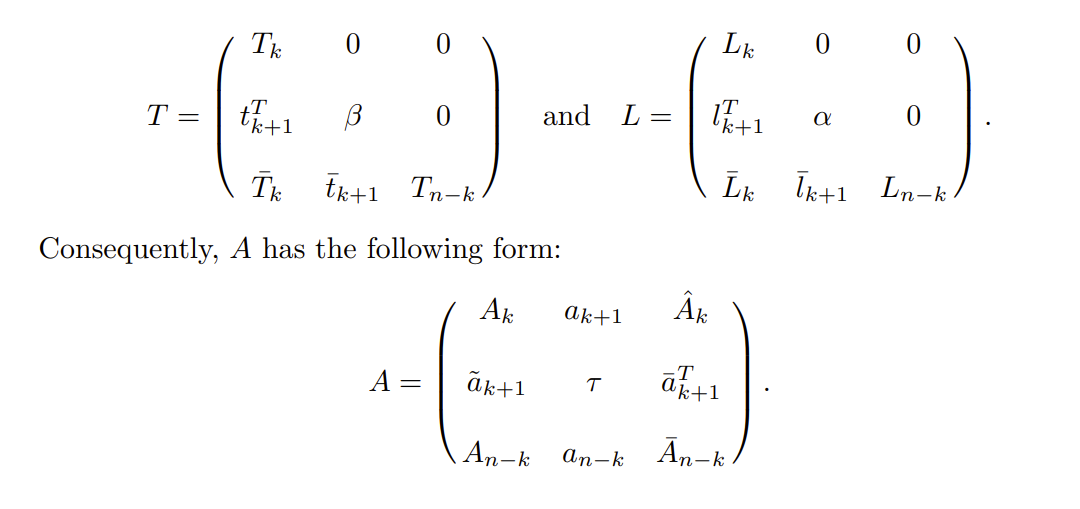

In [21]:
# checa se a matriz é não-singular e assimétrica
def check_st(A):
    return np.linalg.det(A) != 0 and (not np.allclose(A, A.T))

In [22]:
# create random 3x3 matrix
np.random.seed(6661)
A = np.random.rand(4, 4)
check_st(A)

True

In [23]:
A

array([[0.44762768, 0.73308449, 0.31958249, 0.87627054],
       [0.05225297, 0.91087698, 0.38512147, 0.68885618],
       [0.92406379, 0.76413956, 0.5401413 , 0.9579965 ],
       [0.41066384, 0.63203731, 0.14754275, 0.28875699]])

Não consegui implementar o algoritmo do artigo original 😔

Vou tentar uma abordagem diferente, e depois tirar minhas dúvidas.

In [24]:
# usando o truque deste artigo
# https://www.jmest.org/wp-content/uploads/JMESTN42352851.pdf

l, u = linalg.lu(A, permute_l=True)
# T = L*(U')^(-1) 
T = l @ np.linalg.inv(u.T)
# T  - zero below threshold
T[np.abs(T) < 1e-10] = 0
# S = U'*U;
S = u.T @ u
# Check A = T*S;
print(np.allclose(A, T @ S))
# Check S is symmetric
print(np.allclose(S, S.T))

True
True


#### Conjugada

In [25]:
A = np.random.rand(4, 4)
# k = rank of A
k = np.linalg.matrix_rank(A)
k

np.int64(4)

In [26]:
r1 = np.random.rand(A.shape[1])
# p1 = r1 / ||r1||_2
p1 = r1 / np.linalg.norm(r1)

p = np.zeros((k, A.shape[1]))
r = np.zeros((k, A.shape[1]))
q = np.zeros((k, A.shape[1]))
r[0] = r1
p[0] = p1
for i in range(1, k):
    #print(i)
    # q = A @ p_{i-1}
    qk = A @ p[i-1]
    #print(qk.shape)
    r[i] = r[i-1] - A.T @ qk
    p[i] = r[i] + p[i-1]
    p[i] = p[i] / np.linalg.norm(p[i])
    #print(q[i].shape)
    #print((1 / np.sqrt(qk.T @ qk)))
    q[i] = (1 / np.sqrt(qk.T @ qk)) * qk

#  Choose pj orthonormal to all pi for i = 1,···,k and j = k + 1,···,n in null space of A.
ns = linalg.null_space(A)

for i in range(k, A.shape[1]):
    p[i] = ns[:, i - k]
    q[i] = (1 / np.sqrt(p[i].T @ p[i])) @ p[i]

# Choose qj orthonormal to qi with qj 2 =1 in R^m.
for i in range(k, A.shape[1]):
    for j in range(i + 1, A.shape[1]):
        q[j] = q[j] - (q[j].T @ q[i]) * q[i]
    q[j] = q[j] / np.linalg.norm(q[j])

# sigma[i] = sqrt(p[i].T @ A.T @ A @ p[i])
sigma = np.zeros(k)
for i in range(k):
    sigma[i] = np.sqrt(p[i].T @ A.T @ A @ p[i])

# Q = [q1, q2, ..., qn]
Q = q.T
P = p.T

In [27]:
A

array([[0.0224107 , 0.77795325, 0.54961747, 0.72839443],
       [0.4924447 , 0.89850655, 0.25272106, 0.4657542 ],
       [0.39801513, 0.47499047, 0.81074773, 0.11801541],
       [0.93756087, 0.86193651, 0.16010041, 0.65493856]])

In [28]:
Q @ np.diag(sigma) @ np.linalg.pinv(P)

array([[ 584.74818476,    5.81493635, -793.86293328,   45.03220454],
       [ 530.79792139,    5.58194325, -721.08608616,   40.83864611],
       [ 361.17310461,    3.85957597, -490.48990072,   27.72006235],
       [ 676.24306346,    6.89025273, -918.11916369,   52.00722559]])

Tudo errado! Vou tirar minhas dúvidas e corrigir depois.